# Introduction

## Face Recognition with TensorFlow


In [1]:
!pip install split-folders -qqq

In [2]:
import os
import warnings
import splitfolders

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

warnings.simplefilter('ignore')
pd.options.display.float_format = '{:.2f}'.format

tf.__version__ 

2024-07-28 05:05:56.770996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 05:05:56.771117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 05:05:56.909650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

In [3]:
!mkdir face-recognition-dataset

for celeb in ['Hrithik Roshan', 'Henry Cavill', 'Robert Downey Jr']:
    os.system(f'cp -r "/kaggle/input/face-recognition-dataset/Original Images/Original Images/{celeb}" "face-recognition-dataset/{celeb}"')

In [4]:
!ls face-recognition-dataset

'Henry Cavill'	'Hrithik Roshan'  'Robert Downey Jr'


In [5]:
splitfolders.ratio("face-recognition-dataset", output="face-recognition-dataset-splitted", seed=1, ratio=(.8, .2))

Copying files: 320 files [00:00, 3016.91 files/s]


In [6]:
!ls face-recognition-dataset-splitted

train  val


### Training and Testing 


In [7]:
train_path = 'face-recognition-dataset-splitted/train'
val_path = 'face-recognition-dataset-splitted/val'

folders = glob(train_path + '/*')
len(folders)

3

In [8]:
assert list(set(os.listdir('face-recognition-dataset-splitted/train'))) == list(set(os.listdir('face-recognition-dataset-splitted/val')))

### Using a Pre-Trained Model and Resizing the image


In [9]:
# Reset Image size
IMAGE_SIZE = [224, 224] 

# Load Pre-Trained Model
resnet = ResNet50(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet', #Default
    include_top = False  
)

# Using default weights used by imagenet
for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Flatten the output of the ResNet model to convert the 2D feature maps to 1D feature vectors.
x = Flatten()(resnet.output)

# The 'softmax' activation function is used to produce a probability distribution over the classes.
prediction = Dense(len(folders), activation='softmax')(x)

# The model takes the input from the ResNet model and outputs the predictions from the dense layer.
model = Model(inputs=resnet.input, outputs=prediction)

# Print a summary of the model architecture.
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,888,771 (91.13 MB)

 Trainable params: 301,059 (1.15 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Compile the model with the specified loss function, optimizer, and evaluation metrics.


In [11]:
model.compile(
    loss='categorical_crossentropy',  # Loss function used for multi-class classification tasks
    optimizer='adam',                # Optimizer that adjusts the weights of the neural network
    metrics=['accuracy']            
)

### Create an Image Data Generator object for the training and testing data with data augmentation.


In [12]:
"""
-Rescale pixel values to be between 0 and 1 (normalization)
-Apply random shearing transformations to the images
-Apply random zoom transformations to the images
-Randomly flip images horizontally
"""

train_gen = ImageDataGenerator(
    rescale=1./255,              
    shear_range=0.2,           
    zoom_range=0.2,              
    horizontal_flip=True         
)

val_gen = ImageDataGenerator(
    rescale=1./255               # Rescale pixel values to be between 0 and 1 (normalization)
)

### Defining Training and Testing Sets

In [13]:
training_set = train_gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical' 
)

val_set = val_gen.flow_from_directory(
    val_path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False,
)

Found 254 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


### Training the Model

In [14]:
history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=50
)


Epoch 1/50
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2891 - loss: 3.3219 

I0000 00:00:1722143196.370018      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3461 - loss: 4.5381 - val_accuracy: 0.3333 - val_loss: 3.5529
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.3158 - loss: 3.1320 - val_accuracy: 0.4091 - val_loss: 1.4172
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.4592 - loss: 1.3451 - val_accuracy: 0.5000 - val_loss: 1.5330
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.5229 - loss: 1.1246 - val_accuracy: 0.3939 - val_loss: 1.7692
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.5550 - loss: 1.2968 - val_accuracy: 0.4242 - val_loss: 1.6102
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.4188 - loss: 1.3614 - val_accuracy: 0.3788 - val_loss: 1.5296
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5080 - loss: 1.0181 - val_accuracy: 0.3636 - val_loss: 1.6101
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.5673 - loss: 1.0639 - val_accuracy: 0.4545 - val_loss: 1.3541
Epoch

In [15]:
model.save('model.h5')

### Data Visualization


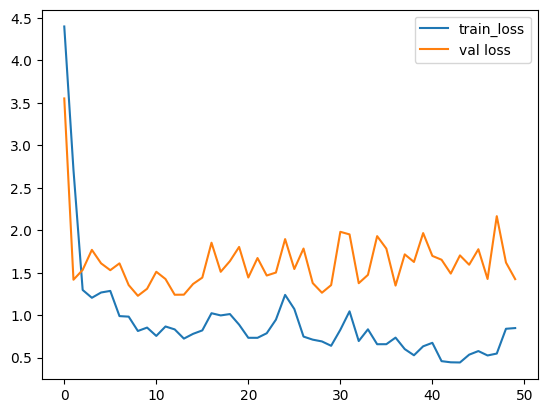

In [16]:
# Plotting the training loss
plt.plot(history.history['loss'], label='train_loss')

# Plotting the validation loss
plt.plot(history.history['val_loss'], label='val loss')

# Adding a legend to distinguish between the training and validation loss plots
plt.legend()

# Displaying the plot
plt.show()

### Plotting Accurancy of the Model


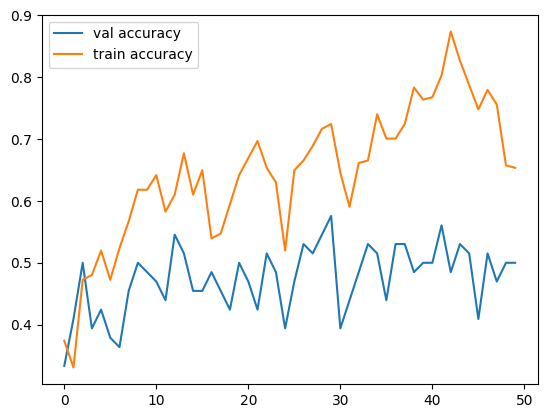

In [17]:
# Plot the Accuracy
plt.plot(history.history['val_accuracy'], label ='val accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend()
plt.show()

### Prediction on test set

In [18]:
prediction = model.predict(val_set)
prediction = np.argmax(prediction, axis = 1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [19]:
true_classes = val_set.classes

In [20]:
accuracy = accuracy_score(true_classes, prediction)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 50.00%


In [21]:
class_labels = list(val_set.class_indices.keys())
report = classification_report(true_classes, prediction, target_names = class_labels, output_dict = True)

report_df = pd.DataFrame(report).transpose()

report_df

,precision,recall,f1-score,support
Henry Cavill,0.38,0.41,0.39,22.00
Hrithik Roshan,0.46,0.57,0.51,21.00
Robert Downey Jr,0.75,0.52,0.62,23.00
accuracy,0.50,0.50,0.50,0.50
macro avg,0.53,0.50,0.51,66.00
weighted avg,0.53,0.50,0.51,66.00


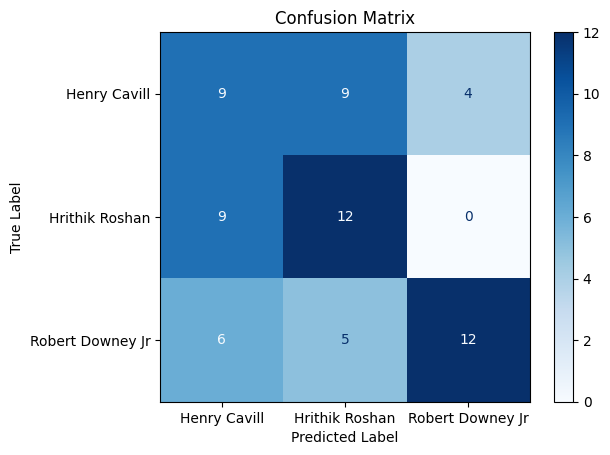

In [22]:
conf_matrix = confusion_matrix(true_classes, prediction)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = class_labels)

cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

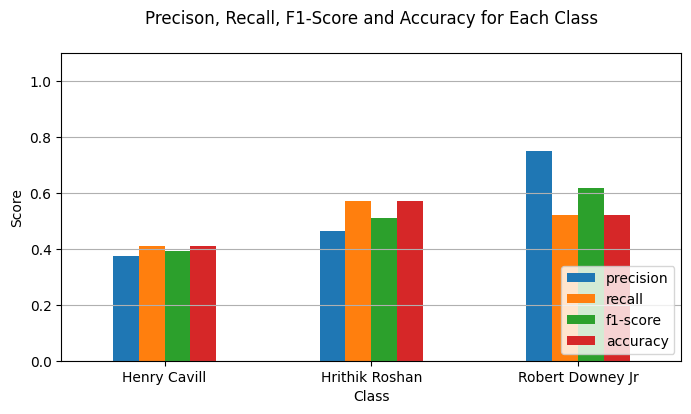

In [23]:
#Plot Precision, Recall and Precision Score
metrics_data = report_df.loc[class_labels, ['precision', 'recall', 'f1-score']]
accuracies = []

for label in class_labels:
    idx = val_set.class_indices[label]
    tp = conf_matrix[idx, idx]
    total = np.sum(conf_matrix[idx, :])
    accuracies.append(tp/total)
    
metrics_data['accuracy'] = accuracies

metrics_data.plot(kind='bar', figsize = (8, 4))

plt.title('Precison, Recall, F1-Score and Accuracy for Each Class\n')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0,1.1)
plt.legend(loc = 'lower right')
plt.xticks(rotation = 0)
plt.grid(axis = 'y')
plt.show()

# Summary and Explanation of Results

The bar chart provides a visual representation of the performance metrics—precision, recall, F1-score, and accuracy—for each class in the face recognition task. The classes shown are "Henry Cavill," "Hrithik Roshan," and "Robert Downey Jr."

## Key Observations
- **Robert Downey Jr**: The model performs well with high scores across all metrics, indicating effective recognition of this class.
- **Henry Cavill and Hrithik Roshan**: Both classes have lower scores in all metrics compared to "Robert Downey Jr." This suggests the model struggles to correctly identify these classes.

## Interpretation
- The model is most effective at identifying "Robert Downey Jr," but struggles with "Henry Cavill" and "Hrithik Roshan."
- The lower performance for "Henry Cavill" and "Hrithik Roshan" suggests a need for more data, better data quality, or additional model tuning for these classes.